In [ ]:
# Downloading all libraries
from google.colab import files, drive
import os
import random
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import transforms, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import numpy as np

# Downloading Dataset using Kaggle API, 

In [ ]:
# To upload Kaggle API json file so we can download the dataset off Kaggle
uploaded = files.upload()

# create a google drive directory
drive.mount('/gdrive')
!ls /gdrive

Saving kaggle.json to kaggle.json
Mounted at /gdrive
MyDrive  Shareddrives


In [ ]:
# installing kaggle library and placing the uploaded kaggle json API file in correct directory for download
# overall this segment ensures all dataset and API key is in the google drive and content folder of the colab to avoid repeat downloads
BASE_PATH = '/gdrive/MyDrive/colab_files/DL_final_project/'
DATA_PATH = '/content/'

if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)

print(os.path.join(BASE_PATH, '.kaggle'))

# double checking if the kaggle has been uploaded to the google drive
if not os.path.exists(os.path.join(BASE_PATH, '.kaggle')):
    os.chdir(BASE_PATH)
    os.makedirs(os.path.join(BASE_PATH, '.kaggle'))
    print("copying the kaggle to the google drive folder")
    !cp /content/kaggle.json /gdrive/MyDrive/colab_files/DL_final_project/.kaggle/kaggle.json

# to ensure that kaggle folder is in the content folder as well for downloading purposes
if not os.path.exists(os.path.join(DATA_PATH, ".kaggle")):
    !cp /gdrive/MyDrive/colab_files/DL_final_project/.kaggle/kaggle.json /content/kaggle.json

!cp /gdrive/MyDrive/colab_files/DL_final_project/.kaggle/kaggle.json /root/.kaggle/kaggle.json

# checking if the dataset exists in the content folder
if not os.path.exists(os.path.join(DATA_PATH, 'asl_alphabet_train')):
    os.chdir(BASE_PATH)

    # double checking if the dataset is not in our google drive folder to avoid downloading from Kaggle repeatedly
    if not os.path.exists(os.path.join(BASE_PATH, 'asl_alphabet_train')):
        !kaggle datasets download -d grassknoted/asl-alphabet
        !unzip asl-alphabet.zip
        !rm asl-alphabet.zip

    # by this point, ensures that all the dataset for the ASL images are in the google drive
    !cp -r /gdrive/MyDrive/colab_files/DL_final_project/asl_alphabet_test /content
    !cp -r /gdrive/MyDrive/colab_files/DL_final_project/asl_alphabet_train /content

os.chdir('/content')

/gdrive/MyDrive/colab_files/DL_final_project/.kaggle
cp: cannot create regular file '/root/.kaggle/kaggle.json': No such file or directory
^C


KeyboardInterrupt: ignored

# Exploring the Dataset

Number of classes present in the alphabet: 29
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


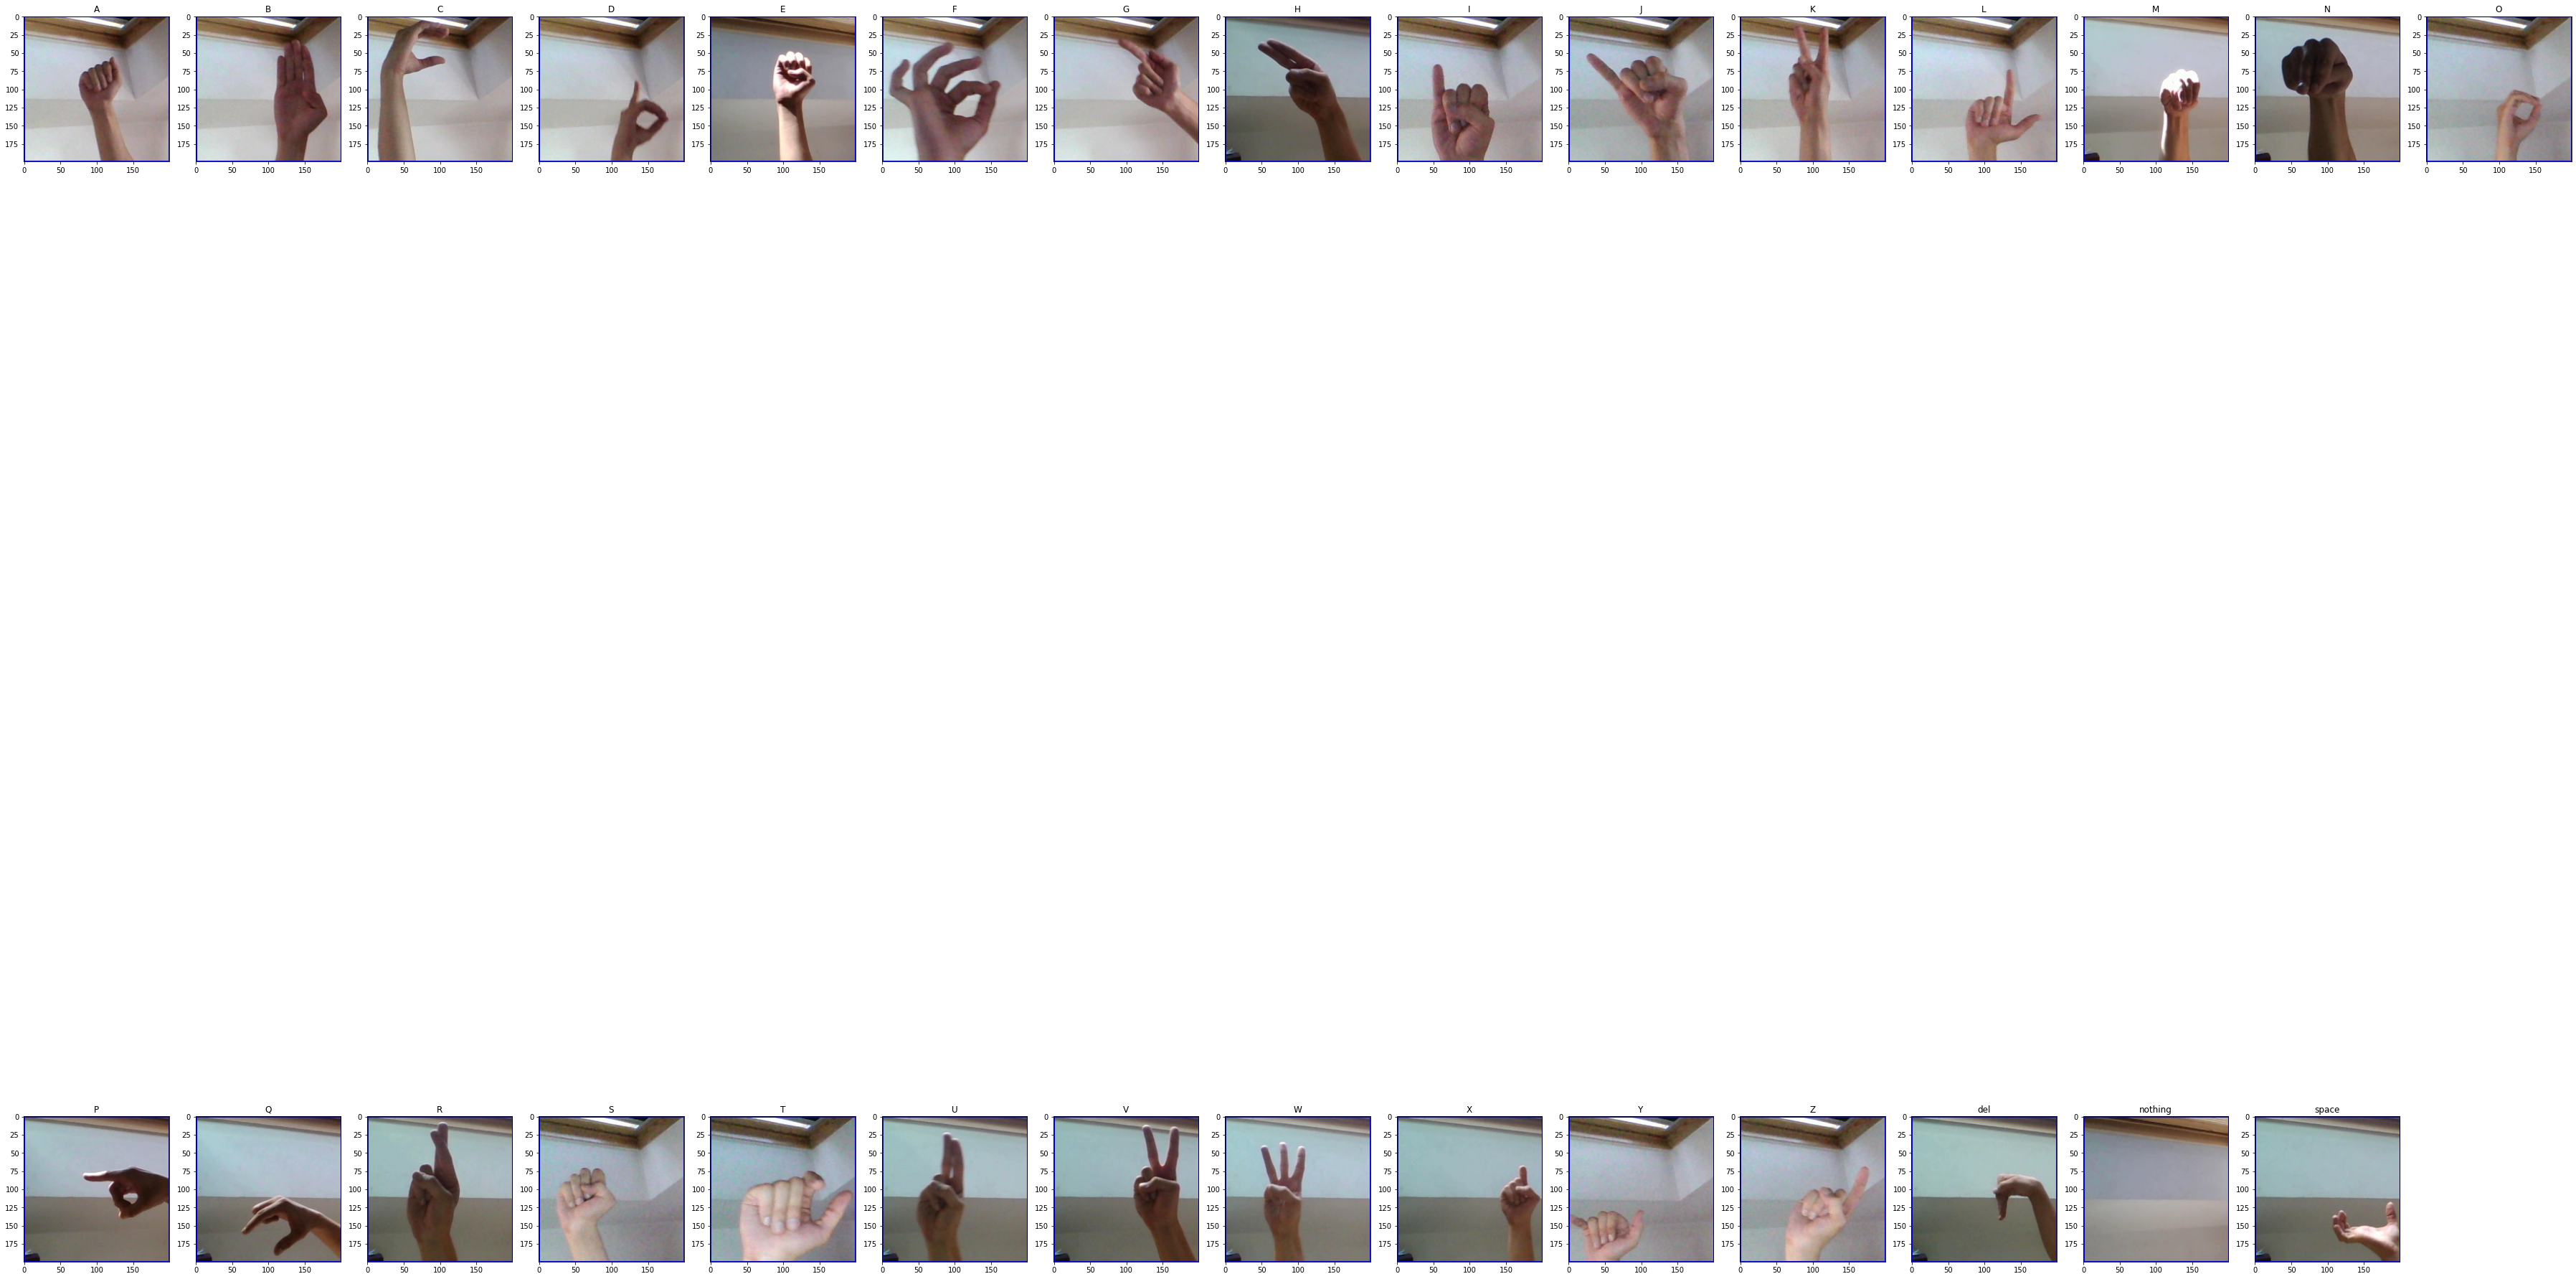

In [ ]:
TRAINING_SET_PATH = DATA_PATH + "/asl_alphabet_train/asl_alphabet_train/"
TESTING_SET_PATH = DATA_PATH + "/asl_alphabet_test/asl_alphabet_test/"

# training set folder contains directory to each alphabet
alphabet_classes = os.listdir(TRAINING_SET_PATH)
alphabet_classes.sort()
print("Number of classes present in the alphabet: " + str(len(alphabet_classes)))
print(alphabet_classes)

num_rows = 2 # to avoid cluttering all images into one column
num_columns = math.ceil(len(alphabet_classes) / num_rows)
fig, ax = plt.subplots(num_rows, num_columns, figsize=(50, 50))

# iterating through each possible alphabet categories and obtaining an example from each
for i, alphabet in enumerate(alphabet_classes):

    #plot.axis("Off") # not doing so results in all the iamges clumped up together
    image = mpimg.imread(os.path.join(TRAINING_SET_PATH, alphabet, alphabet + str(random.randint(1, 2000)) + ".jpg")) # arbitrarily chose the tenth image for each class
    ax[i // num_columns, i % num_columns].imshow(image)
    ax[i // num_columns, i % num_columns].set_title(alphabet)

fig.delaxes(ax[num_rows - 1, num_columns - 1]) # note that we have 29 alphabets for 30 plots, so we need to delete the last plot
plt.tight_layout()
plt.show()

# Data Preparation / Loading the Dataset

In [ ]:
IMAGE_DIM = 200 # 200 x 200 image, so one dim works
BATCH_SIZE = 32 
TEST_BATCH_SIZE = 10

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    ])

# creating official torch dataset based on the folder of images, using the
# ImageFolder function
data_train_val = datasets.ImageFolder(TRAINING_SET_PATH, transform=train_transforms)

In [ ]:
training_set_size = len(data_train_val)
print("Original training set size: " + str(training_set_size))

# splitting the proportion of training/val set into 85% train and 15% val
proportion_train_val = 0.15
validation_set_size = round(training_set_size * proportion_train_val)
training_set_size = training_set_size - validation_set_size
print("Training Set size: " + str(training_set_size))
print("Validation Set size: " + str(validation_set_size))

# randomly splitting the train set into 85% train and 15% val set
data_train, data_val = torch.utils.data.random_split(data_train_val, [training_set_size, validation_set_size])
print("Training Set size: " + str(len(data_train)))
print("Validation Set size: " + str(len(data_val)))


Original training set size: 87000
Training Set size: 73950
Validation Set size: 13050
Training Set size: 73950
Validation Set size: 13050


In [ ]:
# loading dataset into the torch dataloader for the model training/validation
train_dataloader = torch.utils.data.DataLoader(dataset=data_train, batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(dataset=data_val, batch_size=BATCH_SIZE,
                                              shuffle=True)

torch.Size([32, 3, 200, 200]) torch.Size([32])
Ground Truth value: T


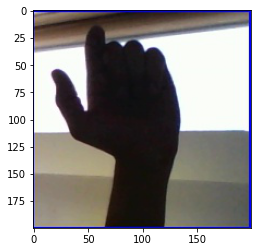

In [ ]:
# testing dataloader
for img, label in train_dataloader:
    print(img.shape, label.shape) # batch size x channel x height x width
    print('Ground Truth value: ' + alphabet_classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0)) # display a single image
    break

# Model Implementation (ASLv1 Model)

In [ ]:
BASE_PATH = '/gdrive/MyDrive/colab_files/DL_final_project/'
DATA_PATH = '/content/'

In [ ]:
sys.path.append(BASE_PATH)

class ASLNet_Version1(nn.Module):
    def __init__(self):
        super(ASLNet_Version1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 2)
        self.maxpool1 = nn.MaxPool2d((3, 3))
        self.conv2 = nn.Conv2d(16, 256, 2)
        self.conv3 = nn.Conv2d(256, 256, 2)
        self.maxpool2 = nn.MaxPool2d((4, 4))
        self.fc1 = nn.Linear(256*256, 420)
        self.fc2 = nn.Linear(420, 29)


        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

### Model Training

In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0


    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            

            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 64
TEST_BATCH_SIZE = 10
EPOCHS = 25
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.10" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}


model = ASLNet_Version1().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = 0

train_losses = []
validation_losses = []
validation_accuracies = []
epochs = []
epochs.append(start_epoch)
validation_loss, validation_accuracy = test(model, device, validation_dataloader)

validation_losses.append(validation_loss)
validation_accuracies.append(validation_accuracy)

try:
    for epoch in range(start_epoch+1, EPOCHS + 1):
        train_loss = train(model, device, train_dataloader, optimizer, epoch, PRINT_INTERVAL)
        validation_loss, validation_accuracy = test(model, device, validation_dataloader)
        epochs.append(epoch)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        print(f"Train Loss: {train_loss}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}");

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    figure, axis = plt.subplots(1, 3)

    axis[0].plot(epochs[:len(epochs) - 1], train_losses)
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Training Loss')
    axis[0].set_title("Train Losses")

    axis[1].plot(epochs, validation_losses)
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('Validation Loss')
    axis[1].set_title("Validation Losses")

    axis[2].plot(epochs, validation_accuracies)
    axis[2].set_xlabel('Epoch')
    axis[2].set_ylabel('Validation Accuracy')
    axis[2].set_title("Validation Accuracies")

    plt.tight_layout()
    plt.show()

### ASLv1 Model Testing and Performance

In [ ]:
mapping = dict()
for i, letter in enumerate(alphabet_classes):
  mapping[letter] = i

In [ ]:
# for creating a dataset pipeline for the test set (different structure)
from pathlib import Path
from PIL import Image

list_test_set = sorted(list(Path(TESTING_SET_PATH).glob('*.jpg')))

num_rows = 4 # to avoid cluttering all images into one column
num_columns = math.ceil(len(alphabet_classes) / num_rows)
fig, ax = plt.subplots(num_rows, num_columns, figsize=(50, 50))

test_correct = 0

model.eval()
with torch.no_grad():
  for i, image_path in enumerate(list_test_set):
      original_image = Image.open(image_path).convert('RGB') # getting the image opened
      original_label = image_path.parts[-1].split('_')[0]

      test_transforms = transforms.Compose([
                    transforms.ToTensor(),
              ])
      
      image = test_transforms(original_image)

      image = image.reshape([1, 3, 200, 200])

      label = torch.tensor(mapping[original_label]).reshape([1, 1])
      data, label = image.to(device), label.to(device)

      output = model(data)
      pred = output.max(1)[1]
      prediction = alphabet_classes[pred[0].item()]
      if prediction == original_label:
          test_correct += 1

      original_image = mpimg.imread(image_path) # arbitrarily chose the tenth image for each class
      ax[i // num_columns, i % num_columns].imshow(original_image)
      ax[i // num_columns, i % num_columns].set_title("Label: " + original_label + ", Prediction: " + prediction, fontsize=30)


  fig.delaxes(ax[num_rows - 1, num_columns - 1]) 
  fig.delaxes(ax[num_rows - 1, num_columns - 2])
  fig.delaxes(ax[num_rows - 1, num_columns - 3]) 
  fig.delaxes(ax[num_rows - 1, num_columns - 4]) 

  plt.tight_layout()
  plt.show()

print("The total accuracy for test set was: " + str(test_correct / len(list_test_set)))

# Model Implementation (ASLv2 Model)

In [ ]:
sys.path.append(BASE_PATH)

class ASLNet_Version2(nn.Module):
    def __init__(self):
        super(ASLNet_Version2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.fc1 = nn.Linear(135424, 512)
        self.fc2 = nn.Linear(512, 29)

        self.maxpool1 = nn.MaxPool2d((2, 2))
        self.maxpool2 = nn.MaxPool2d((4, 4))
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.maxpool1(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.maxpool2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val



# Visualizing Model Architecture

In [ ]:
from torchsummary import summary

v1 = ASLNet_Version1().to("cuda")
v2 = ASLNet_Version2().to("cuda")
summary(v1, (3, 200, 200))
summary(v2, (3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 199, 199]             208
         MaxPool2d-2           [-1, 16, 66, 66]               0
            Conv2d-3          [-1, 256, 65, 65]          16,640
            Conv2d-4          [-1, 256, 64, 64]         262,400
         MaxPool2d-5          [-1, 256, 16, 16]               0
            Linear-6                  [-1, 420]      27,525,540
            Linear-7                   [-1, 29]          12,209
Total params: 27,816,997
Trainable params: 27,816,997
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 22.12
Params size (MB): 106.11
Estimated Total Size (MB): 128.69
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)          

In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 64
TEST_BATCH_SIZE = 10
EPOCHS = 10
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.00005

EXPERIMENT_VERSION = "0.10" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

model = ASLNet_Version2().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = 0

train_losses = []
validation_losses = []
validation_accuracies = []
epochs = []
epochs.append(start_epoch)
validation_loss, validation_accuracy = test(model, device, validation_dataloader)

validation_losses.append(validation_loss)
validation_accuracies.append(validation_accuracy)

try:
    for epoch in range(start_epoch+1, EPOCHS + 1):
        train_loss = train(model, device, train_dataloader, optimizer, epoch, PRINT_INTERVAL)
        validation_loss, validation_accuracy = test(model, device, validation_dataloader)
        epochs.append(epoch)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        print(f"Train Loss: {train_loss}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}");

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    figure, axis = plt.subplots(1, 3)

    axis[0].plot(epochs[:len(epochs) - 1], train_losses)
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Training Loss')
    axis[0].set_title("Train Losses")

    axis[1].plot(epochs, validation_losses)
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('Validation Loss')
    axis[1].set_title("Validation Losses")

    axis[2].plot(epochs, validation_accuracies)
    axis[2].set_xlabel('Epoch')
    axis[2].set_ylabel('Validation Accuracy')
    axis[2].set_title("Validation Accuracies")

    plt.tight_layout()
    plt.show()

### ASLv2 Model Testing and Performance Analysis

In [ ]:
mapping = dict()
for i, letter in enumerate(alphabet_classes):
  mapping[letter] = i

In [ ]:
from pathlib import Path
from PIL import Image

list_test_set = sorted(list(Path(TESTING_SET_PATH).glob('*.jpg')))

num_rows = 4 # to avoid cluttering all images into one column
num_columns = math.ceil(len(alphabet_classes) / num_rows)
fig, ax = plt.subplots(num_rows, num_columns, figsize=(50, 50))

test_correct = 0

model.eval()
with torch.no_grad():
  for i, image_path in enumerate(list_test_set):
      original_image = Image.open(image_path).convert('RGB') # getting the image opened
      original_label = image_path.parts[-1].split('_')[0]

      test_transforms = transforms.Compose([
                    transforms.ToTensor(),
              ])
      
      image = test_transforms(original_image)

      image = image.reshape([1, 3, 200, 200])

      label = torch.tensor(mapping[original_label]).reshape([1, 1])
      data, label = image.to(device), label.to(device)

      output = model(data)
      pred = output.max(1)[1]
      prediction = alphabet_classes[pred[0].item()]
      if prediction == original_label:
          test_correct += 1

      original_image = mpimg.imread(image_path) # arbitrarily chose the tenth image for each class
      ax[i // num_columns, i % num_columns].imshow(original_image)
      ax[i // num_columns, i % num_columns].set_title("Label: " + original_label + ", Prediction: " + prediction, fontsize=30)


  fig.delaxes(ax[num_rows - 1, num_columns - 1]) 
  fig.delaxes(ax[num_rows - 1, num_columns - 2])
  fig.delaxes(ax[num_rows - 1, num_columns - 3]) 
  fig.delaxes(ax[num_rows - 1, num_columns - 4]) 

  plt.tight_layout()
  plt.show()

print("The total accuracy for test set was: " + str(test_correct / len(list_test_set)))

# Model Implementation (AlexNet)

### We also plan to compare our networks to a pretrained one for general image classification, in this case we are using AlexNet.

In [ ]:
alexnet_pretrained = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
alexnet_pretrained.eval()
for param in alexnet_pretrained.parameters():
     param.requires_grad = False

layers = list(alexnet_pretrained.classifier.children())[:-2] # Remove last 2 layers
layers.extend([nn.Linear(4096, 512)]) # Add
layers.extend([nn.ReLU(inplace=True)]) # Add
layers.extend([nn.Linear(512, 29)]) # Add
alexnet_pretrained.classifier = nn.Sequential(*layers) # Replace the model classifier

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

### Modified Train and Test Functions to Freeze Weights for AlexNet

In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, label.squeeze(), reduction="mean")
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = F.cross_entropy(output, label.squeeze(), reduction="mean").item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

### Training AlexNet's last layer to fit the number of output classes

Original training set size: 87000
Training Set size: 73950
Validation Set size: 13050
Training Set size: 73950
Validation Set size: 13050
Using device cuda
num cpus: 2

Test set: Average loss: 0.1238, Accuracy: 497/13050 (4%)

Thu Dec  8 07:37:31 2022 Train Epoch: 1 [0/73950 (0%)]	Loss: 3.944854
Thu Dec  8 07:37:39 2022 Train Epoch: 1 [3200/73950 (4%)]	Loss: 3.368110
Thu Dec  8 07:37:47 2022 Train Epoch: 1 [6400/73950 (9%)]	Loss: 3.366073
Thu Dec  8 07:37:55 2022 Train Epoch: 1 [9600/73950 (13%)]	Loss: 3.369298
Thu Dec  8 07:38:03 2022 Train Epoch: 1 [12800/73950 (17%)]	Loss: 3.361583
Thu Dec  8 07:38:10 2022 Train Epoch: 1 [16000/73950 (22%)]	Loss: 3.364446
Thu Dec  8 07:38:18 2022 Train Epoch: 1 [19200/73950 (26%)]	Loss: 3.358769
Thu Dec  8 07:38:26 2022 Train Epoch: 1 [22400/73950 (30%)]	Loss: 3.383778
Thu Dec  8 07:38:33 2022 Train Epoch: 1 [25600/73950 (35%)]	Loss: 3.039349
Thu Dec  8 07:38:40 2022 Train Epoch: 1 [28800/73950 (39%)]	Loss: 3.151576
Thu Dec  8 07:38:48 2022 Train Ep

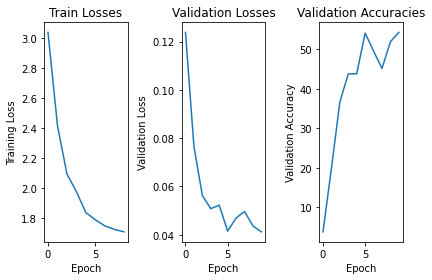

In [ ]:
# THIS CODE FREEZES WEIGHTS, SO PLEASE DENOTE THIS AS SUCH AND DO NOT REUSE THIS CELL

IMAGE_DIM = 200 # 200 x 200 image, so one dim works
BATCH_SIZE = 32 
TEST_BATCH_SIZE = 10

train_transforms = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    ])

training_set_size = len(data_train_val)
print("Original training set size: " + str(training_set_size))

# splitting the proportion of training/val set into 85% train and 15% val
proportion_train_val = 0.15
validation_set_size = round(training_set_size * proportion_train_val)
training_set_size = training_set_size - validation_set_size
print("Training Set size: " + str(training_set_size))
print("Validation Set size: " + str(validation_set_size))

# randomly splitting the train set into 85% train and 15% val set
data_train, data_val = torch.utils.data.random_split(data_train_val, [training_set_size, validation_set_size])
print("Training Set size: " + str(len(data_train)))
print("Validation Set size: " + str(len(data_val)))

# creating official torch dataset based on the folder of images, using the
# ImageFolder function
data_train_val = datasets.ImageFolder(TRAINING_SET_PATH, transform=train_transforms)

# loading dataset into the torch dataloader for the model training/validation
train_dataloader = torch.utils.data.DataLoader(dataset=data_train, batch_size=BATCH_SIZE,
                                              shuffle=True)

validation_dataloader = torch.utils.data.DataLoader(dataset=data_val, batch_size=BATCH_SIZE,
                                              shuffle=True)

# Play around with these constants, you may find a better setting.
BATCH_SIZE = 32
TEST_BATCH_SIZE = 10
EPOCHS = 40
LEARNING_RATE = 0.005
MOMENTUM = 0.6
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

model = alexnet_pretrained.to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = 0

train_losses = []
validation_losses = []
validation_accuracies = []
epochs = []
epochs.append(start_epoch)
validation_loss, validation_accuracy = test(model, device, validation_dataloader)

validation_losses.append(validation_loss)
validation_accuracies.append(validation_accuracy)

try:
    for epoch in range(start_epoch+1, EPOCHS + 1):
        train_loss = train(model, device, train_dataloader, optimizer, epoch, PRINT_INTERVAL)
        validation_loss, validation_accuracy = test(model, device, validation_dataloader)
        epochs.append(epoch)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        print(f"Train Loss: {train_loss}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}");

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    figure, axis = plt.subplots(1, 3)

    axis[0].plot(epochs[:len(epochs) - 1], train_losses)
    axis[0].set_xlabel('Epoch')
    axis[0].set_ylabel('Training Loss')
    axis[0].set_title("Train Losses")

    axis[1].plot(epochs, validation_losses)
    axis[1].set_xlabel('Epoch')
    axis[1].set_ylabel('Validation Loss')
    axis[1].set_title("Validation Losses")

    axis[2].plot(epochs, validation_accuracies)
    axis[2].set_xlabel('Epoch')
    axis[2].set_ylabel('Validation Accuracy')
    axis[2].set_title("Validation Accuracies")

    plt.tight_layout()
    plt.show()

### AlexNet Model Testing and Performance Analysis

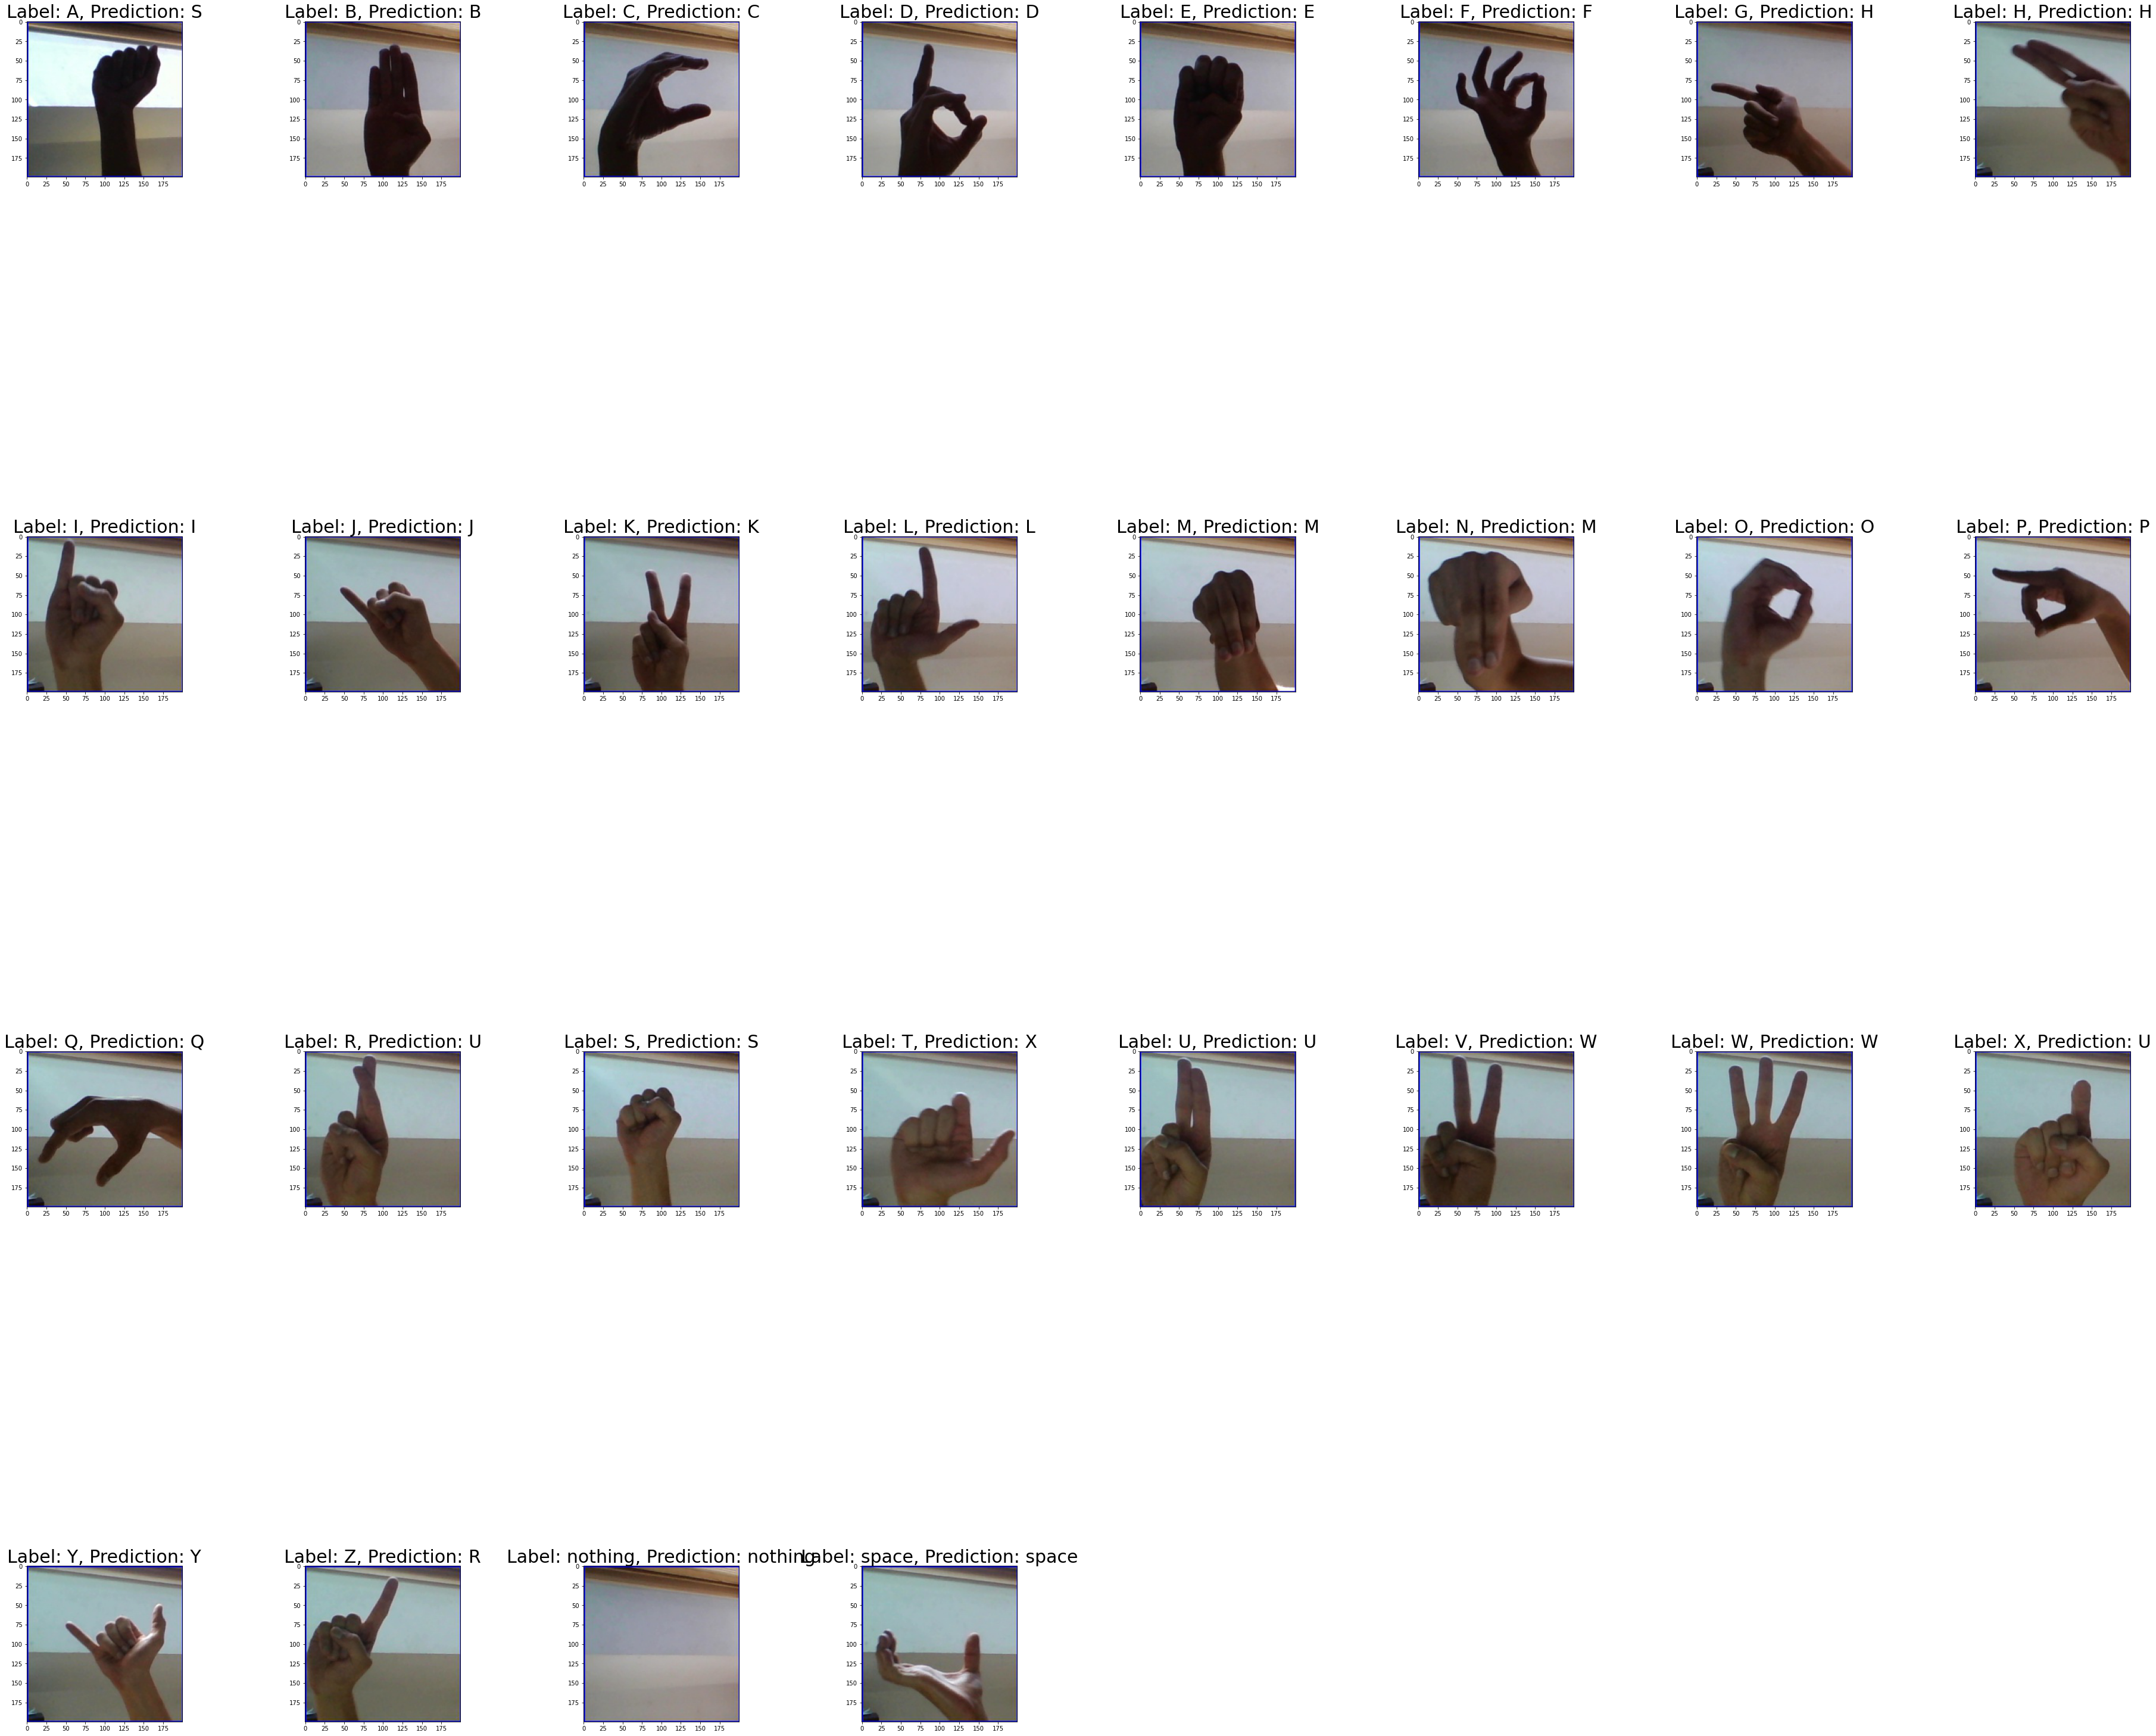

The total accuracy for test set was: 0.7142857142857143


In [ ]:
mapping = dict()
for i, letter in enumerate(alphabet_classes):
  mapping[letter] = i

# for creating a dataset pipeline for the test set (different structure)
from pathlib import Path
from PIL import Image

list_test_set = sorted(list(Path(TESTING_SET_PATH).glob('*.jpg')))

num_rows = 4 # to avoid cluttering all images into one column
num_columns = math.ceil(len(alphabet_classes) / num_rows)
fig, ax = plt.subplots(num_rows, num_columns, figsize=(50, 50))

test_correct = 0

model.eval()
with torch.no_grad():
  for i, image_path in enumerate(list_test_set):
      original_image = Image.open(image_path).convert('RGB') # getting the image opened
      original_label = image_path.parts[-1].split('_')[0]

      test_transforms = transforms.Compose([
                    transforms.ToTensor(),
              ])
      
      image = test_transforms(original_image)

      image = image.reshape([1, 3, 200, 200])

      label = torch.tensor(mapping[original_label]).reshape([1, 1])
      data, label = image.to(device), label.to(device)

      output = model(data)
      pred = output.max(1)[1]
      prediction = alphabet_classes[pred[0].item()]
      if prediction == original_label:
          test_correct += 1

      original_image = mpimg.imread(image_path) # arbitrarily chose the tenth image for each class
      ax[i // num_columns, i % num_columns].imshow(original_image)
      ax[i // num_columns, i % num_columns].set_title("Label: " + original_label + ", Prediction: " + prediction, fontsize=30)


  fig.delaxes(ax[num_rows - 1, num_columns - 1]) 
  fig.delaxes(ax[num_rows - 1, num_columns - 2])
  fig.delaxes(ax[num_rows - 1, num_columns - 3]) 
  fig.delaxes(ax[num_rows - 1, num_columns - 4]) 

  plt.tight_layout()
  plt.show()

print("The total accuracy for test set was: " + str(test_correct / len(list_test_set)))